# Imports

In [47]:
from music21 import *
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model

# Config variables

In [54]:
path = "schubert/"
frequent_notes_threshold = 50

n_of_timesteps = 32
evaluation_percentage = 0.2 # 20% of the data will be used as evaluation

output_dimension = 100
kernel_size = 3
epochs = 50

len_of_predictions = 30

# Aux functions

In [9]:
def read_midi(file):
    
    print("Reading: " + file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [50]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

# Core code

## Read files

In [10]:
files=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path+i) for i in files], dtype=object)

notes_ = [element for note_ in notes_array for element in note_]

Reading: schubert/schumm-1.mid
Reading: schubert/schumm-2.mid
Reading: schubert/schub_d960_4.mid
Reading: schubert/schumm-3.mid
Reading: schubert/schub_d960_1.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2002 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Reading: schubert/schumm-6.mid
Reading: schubert/schumm-4.mid
Reading: schubert/schub_d960_2.mid
Reading: schubert/schub_d960_3.mid
Reading: schubert/schumm-5.mid
Reading: schubert/schuim-4.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1996 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Reading: schubert/schuim-1.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2007 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Reading: schubert/schuim-3.mid
Reading: schubert/schuim-2.mid
Reading: schubert/schubert_D850_4.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Reading: schubert/schubert_D935_4.mid
Reading: schubert/schub_d760_4.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Reading: schubert/schubert_D850_1.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2009 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Reading: schubert/schubert_D935_1.mid
Reading: schubert/schub_d760_1.mid
Reading: schubert/schubert_D850_2.mid
Reading: schubert/schub_d760_3.mid
Reading: schubert/schubert_D935_2.mid
Reading: schubert/schubert_D935_3.mid
Reading: schubert/schubert_D850_3.mid
Reading: schubert/schub_d760_2.mid
Reading: schubert/schu_143_2.mid
Reading: schubert/schu_143_3.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1999 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Reading: schubert/schu_143_1.mid
345


/var/folders/xy/dzytbyv51dd88zf00d9qj1100000gn/T/ipykernel_35503/2898075006.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_midi(path+i) for i in files])


## Analyze data

In [ ]:
unique_notes = list(set(notes_))
print(len(unique_notes))

(array([221.,  40.,  31.,  13.,   8.,   3.,   7.,   9.,   7.,   6.]),
 array([1.0000e+00, 1.6170e+02, 3.2240e+02, 4.8310e+02, 6.4380e+02,
        8.0450e+02, 9.6520e+02, 1.1259e+03, 1.2866e+03, 1.4473e+03,
        1.6080e+03]),
 <BarContainer object of 10 artists>)

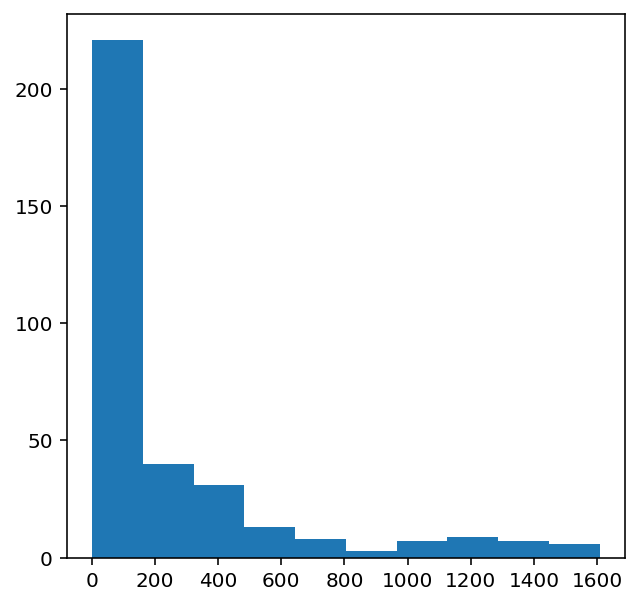

In [13]:
# Notes frequency
freq = dict(Counter(notes_))

no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

## Preparing data

In [21]:
frequent_notes = [note_ for note_, count in freq.items() if count>=frequent_notes_threshold]

# Get the same dataset only with frequent notes
new_music=[]

for notes in notes_array:
    new_music.append([note for note in notes if note in frequent_notes])
    
new_music = np.array(new_music, dtype=object)

In [27]:
inputs = []
outputs = []

for notes_ in new_music:
    for i in range(0, len(notes_) - n_of_timesteps, 1):
        
        inputs.append(notes_[i:i + n_of_timesteps])
        outputs.append(notes_[i + n_of_timesteps])
        
inputs=np.array(inputs)
outputs=np.array(outputs)

In [30]:
unique_inputs = list(set(inputs.ravel()))
input_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_inputs))

input_seq=[]
for input_ in inputs:
    input_seq.append([input_note_to_int[note_] for note_ in input_])
    
input_seq = np.array(input_seq)

In [31]:
unique_outputs = list(set(outputs))
output_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_outputs)) 
output_seq = np.array([output_note_to_int[note_] for note_ in outputs])

## Split data into training and evaluation

In [42]:
input_training, input_validation, output_training, output_validation = train_test_split(input_seq,output_seq,test_size=evaluation_percentage,random_state=0)

## Build model

In [35]:
# LSTM architecture. We will use WaveNet for now
# def lstm():
#   model = Sequential()
#   model.add(LSTM(128,return_sequences=True))
#   model.add(LSTM(128))
#   model.add(Dense(256))
#   model.add(Activation('relu'))
#   model.add(Dense(n_vocab))
#   model.add(Activation('softmax'))
#   model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#   return model

In [41]:
K.clear_session()
model = Sequential()

# Parameters explanation: https://keras.io/api/layers/core_layers/embedding/
model.add(Embedding(len(unique_inputs), output_dimension, input_length=n_of_timesteps,trainable=True)) 

# Parameters explanation: https://keras.io/api/layers/convolution_layers/convolution1d/
model.add(Conv1D(n_of_timesteps*2,kernel_size, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(n_of_timesteps*4,kernel_size,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(n_of_timesteps*8,kernel_size,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())

# Parameters explanation: https://keras.io/api/layers/core_layers/dense/
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_outputs), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           18200     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

## Fit model

In [44]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(input_training),np.array(output_training), batch_size=128, epochs=epochs, validation_data=(np.array(input_validation),np.array(output_validation)),verbose=1, callbacks=[checkpoint])

2021-09-11 18:52:06.399029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
492/492 [==============================] - 36s 69ms/step - loss: 4.3776 - val_loss: 4.0932

Epoch 00001: val_loss improved from inf to 4.09325, saving model to best_model.h5
Epoch 2/50
492/492 [==============================] - 33s 67ms/step - loss: 3.8433 - val_loss: 3.9081

Epoch 00002: val_loss improved from 4.09325 to 3.90807, saving model to best_model.h5
Epoch 3/50
492/492 [==============================] - 36s 73ms/step - loss: 3.6757 - val_loss: 3.7833

Epoch 00003: val_loss improved from 3.90807 to 3.78328, saving model to best_model.h5
Epoch 4/50
492/492 [==============================] - 29s 59ms/step - loss: 3.5576 - val_loss: 3.6738

Epoch 00004: val_loss improved from 3.78328 to 3.67382, saving model to best_model.h5
Epoch 5/50
492/492 [==============================] - 29s 60ms/step - loss: 3.4763 - val_loss: 3.6402

Epoch 00005: val_loss improved from 3.67382 to 3.64024, saving model to best_model.h5
Epoch 6/50
492/492 [==============================] - 34s 7

492/492 [==============================] - 30s 62ms/step - loss: 2.6219 - val_loss: 3.1451

Epoch 00047: val_loss did not improve from 3.14000
Epoch 48/50
492/492 [==============================] - 29s 60ms/step - loss: 2.6212 - val_loss: 3.1300

Epoch 00048: val_loss improved from 3.14000 to 3.12996, saving model to best_model.h5
Epoch 49/50
492/492 [==============================] - 29s 60ms/step - loss: 2.6079 - val_loss: 3.1339

Epoch 00049: val_loss did not improve from 3.12996
Epoch 50/50
492/492 [==============================] - 29s 60ms/step - loss: 2.6058 - val_loss: 3.1292

Epoch 00050: val_loss improved from 3.12996 to 3.12916, saving model to best_model.h5


In [46]:
model = load_model('best_model.h5')

## Generate music!

In [70]:
ind = np.random.randint(0,len(input_validation)-1)

random_music = input_validation[ind]
        
predictions=[]
for i in range(len_of_predictions):

    random_music = random_music.reshape(1,n_of_timesteps)

    prob   = model.predict(random_music)[0]
    output_pred = np.argmax(prob,axis=0)
    predictions.append(output_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),output_pred)
    random_music = random_music[1:]

In [71]:
input_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_inputs)) 
predicted_notes = [input_int_to_note[i] for i in predictions]
print(predicted_notes)

['D5', '7.9', '7.9', '7.9', '1.7', '7.9', '1.7', '2.6', '2.6', '2.7', '7.11', '7.11', '7.11', '7.11', '7.11', '7.11', '7.11', '2.7', '7.11', '2.7', '7.11', '7.11', '2.7', '7.11', '7.11', '2.7', '7.11', '7.11', '7.11', '7.11']


In [72]:
convert_to_midi(predicted_notes)